
#**PATTERN RECOGNITION REPORT TEAM VCV FETAL SOUNDS SET: A MODEL THAT CATEGORIZES FETAL AND NON FETAL SOUNDS WITH 0.997 ACCURACY**.

## **ACKNOWLEDGEMENTS**

The accomplishment of this initiative is due to the priceless assistance and contributions from several people and organizations. Our profound appreciation to Shiraz University (SU) for granting us access to the Fetal Heart Sounds Database (SUFHSDB) is due here. This resource was essential to the conception and creation of our model. We also thank the GitHub repository for providing us with access to important datasets.
We would like to sincerely thank our classmates from the imaging and fetal teams for their excellent presentations and perceptive observations. Their cooperative efforts made a substantial contribution to our project's success.
We would also want to thank our tutors for giving us this wonderful opportunity and for kindly lending us their time and resources to help us with the development process.Their mentoring had a significant impact on how our work turned out.
Finally, we acknowledge and value the divine direction of the All-Powerful God, who guided us through each stage and obstacle of the creation of this model. We are appreciative of the courage and insight this course unit has given us.

## INTRODUCTION

Fetal heart rate (FHR) monitoring is a crucial aspect of prenatal care, providing valuable insights into fetal well-being. Traditionally, FHR monitoring has relied on external devices like dopplers and cardiotocography (CTG) machines. However, these methods can be limited in their ability to continuously monitor FHR, especially in early pregnancy or during fetal movement.

Recent advancements in machine learning have opened up new possibilities for fetal audio classification. By analyzing the acoustic signals captured from a pregnant woman's abdomen, machine learning algorithms can distinguish between fetal heart sounds and non-fetal sounds, such as maternal heartbeat, abdominal noises, and external sounds. This ability has the potential to revolutionize fetal monitoring, enabling continuous and non-invasive assessment of fetal health throughout pregnancy.

This notebook explores the development of a machine learning model for classifying fetal audio and non-fetal audio. We will utilize various machine learning techniques, including feature extraction, model training, and performance evaluation, to create a robust and accurate classification system. The goal is to develop a model that can effectively distinguish between fetal heart sounds and non-fetal sounds, paving the way for continuous and reliable fetal monitoring.
##**1.DATA COLLECTION**

The team didnot collect their own data due to the limited time and resources. however, we employed the online dataset sources including Kaggle, physionet, zindi among others to select suitable datasets for this model. two datasets were used: Shiraz University fetal heart sounds database from Physionet and ESC-50 dataset from the github repository as shall be further demonstrated in the notebook.

The Shiraz University (SU) fetal heart sounds database (SUFHSDB) contains fetal and maternal phonocardiogram (PCG) recordings from 109 pregnant women in single and twin pregnancies. The recordings were made at Hafez Hospital of Shiraz University of Medical Sciences, Shiraz, Iran, from mothers aged from 16 to 47 years with a digital stethoscope placed on the lower maternal abdomen. In total, 99 subjects had one signal recorded, three subjects had two and seven cases of twins were recorded individually, resulting in 119 recordings. The average duration of each record is about 90 seconds. The sampling rate was generally 16,000 Hz with 16-bit quantization and a few recordings at 44,100 Hz. The data was recorded in wide-band mode of the digital stethoscope, with a frequency response of 20 Hz to 1 kHz.

The ESC-50 dataset is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.The dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories.

## **1.1DATA DESCRIPTION**
### **SUFHSDB**
In total, 99 subjects had one signal recorded, three subjects had two and seven cases of twins were recorded individually, resulting in 119 total recordings. The average duration of each record is about 90 seconds. The sampling rate was generally 16,000 Hz with 16-bit quantization and a few recordings at 44,100 Hz. The data was recorded in wide-band mode of the digital stethoscope, with a frequency response of 20 Hz to 1 kHz.

In most cases (91 subjects), the heart sounds of the mothers were also recorded before each fetal PCG recording session. As a result, a total number of 92 maternal heart sounds data are also available in the dataset (90 subjects with one heart sound signal and one subject with two signals recorded, resulting in 92 files in total).

The record names are in the form fX or mX where f stands for fetal recording, m stands for maternal recording, and X is the subject number. The data are in standard audio WAV (.wav) format and WFDB headers (.hea) are provided for reading the data description in WFDB format. An Excel spreadsheet (.xlsx) is also provided, which contains: subject ID, number of gravid/alive/abortions of the mother, maternal BMI, pregnancy term (weeks), gender of the fetus, mother’s age, clinical history (if available), average CTG heart-rate over 10-second windows (whenever available).

### **ESC-50**
Clips in this dataset have been manually extracted from public field recordings gathered by the Freesound.org project. The dataset has been prearranged into 5 folds for comparable cross-validation, making sure that fragments from the same original source file are contained in a single fold.



### **1.2DATA CLEANING AND PREPROCESSING**
#### **INSTALLING AND IMPORTING DEPENDENCES**
We mounted the datasets onto the drive in order to access our data very easily.

##### Mounting the drive

In [76]:

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Installing the Dependencies

##### Importing the Dependencies

In [77]:
# Importing the necessary libraries
import librosa
import numpy as np
import pandas as pd
import csv
import os
import seaborn as sns
import random

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import tensorflow as tf


from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

! pip install pydub
from pydub import AudioSegment

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import keras
from keras.models import Sequential
from keras import layers


#### **Cleaning and Preparing the data the Data**

##### Spliting the 30 seconds fetal audios into six, 5 seconds segments to match duration with the ESC-50 audios

In [78]:
# Function to split audio into segments
def split_audio(input_path, output_folder, segment_duration=5000):
    # Load the audio file
    audio = AudioSegment.from_file(input_path)

    # Get the original file name without extension
    original_filename = os.path.splitext(os.path.basename(input_path))[0]

    # Split the audio into segments
    for i in range(6):
        start_time = i * segment_duration
        end_time = (i + 1) * segment_duration
        segment = audio[start_time:end_time]

        # Save each segment to the output folder with original file name and segment number
        output_path = os.path.join(output_folder, f"{original_filename}_segment_{i+1}.wav")
        if output_path not in output_folder:
          segment.export(output_path, format="wav")

# Specify the input folder path and output folder
input_folder = '/content/drive/MyDrive/fetal'
output_folder = '/content/drive/MyDrive/audio/split_fetal'

# Iterate through each file in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".wav"):  # Assuming you are working with WAV files
        input_audio_path = os.path.join(input_folder, filename)

        # Call the function to split the audio
        split_audio(input_audio_path, output_folder, segment_duration=5000)

print (f"All the 30 seconds audios have been split into six, 5 seconds segments and all of them saved to {output_folder}")



All the 30 seconds audios have been split into six, 5 seconds segments and all of them saved to /content/drive/MyDrive/audio/split_fetal


##### Adding the all the files in the fetal and non fetal audio folders into one List "all_files"

In [79]:

# Declaring the paths to the two different folders
fetal_path = '/content/drive/MyDrive/audio/split_fetal'
non_fetal_path = '/content/drive/MyDrive/audio/audio'

# Get the list of audio files in each folder
fetal_files = [os.path.join(fetal_path, file) for file in os.listdir(fetal_path) if file.endswith(".wav")]
non_fetal_files = [os.path.join(non_fetal_path, file) for file in os.listdir(non_fetal_path) if file.endswith(".wav")]
all_files = fetal_files + non_fetal_files

In [80]:
print(len(all_files))

3060


##### Labelling the Data

#### Visualizing a Random Audio file from the joint list "all_files "

In [81]:
# Selecting the random file
file_path  = random.choice(all_files)
print("Random File Path:", file_path)

# Listening to the random audio
ipd.Audio(file_path)

Random File Path: /content/drive/MyDrive/audio/split_fetal/f39_segment_5.wav


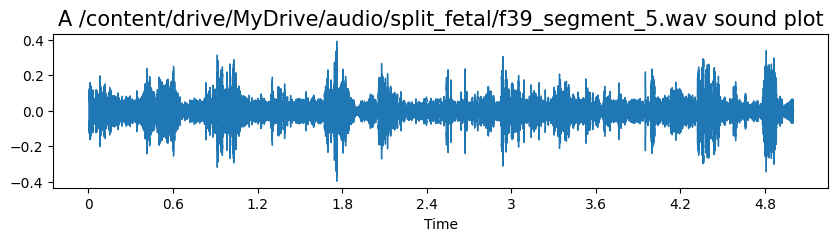

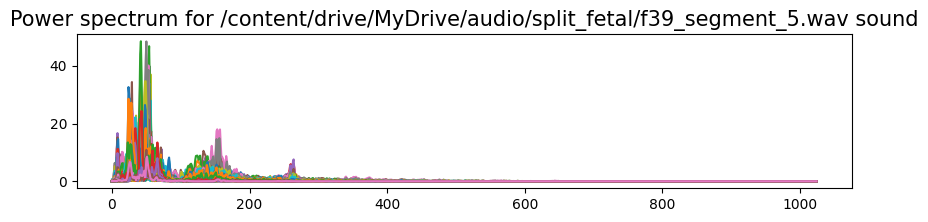

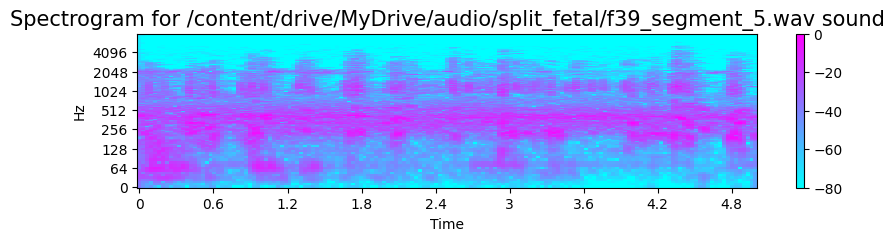

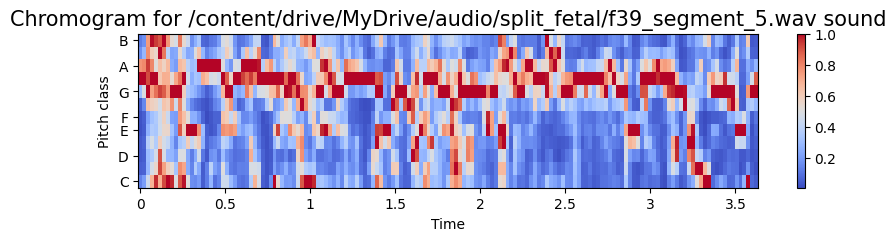

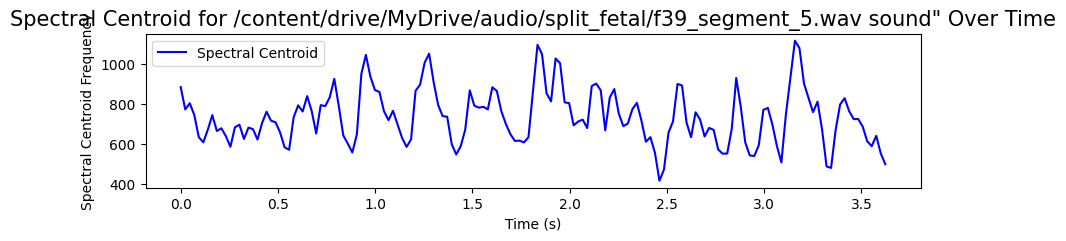

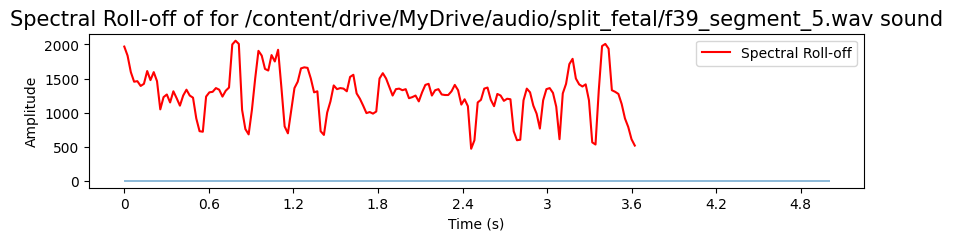

In [82]:

# Load encoded wav file
wav, sr = librosa.load(file_path, sr= 16000, mono=True, duration=5000)

# The plot for the test audio
plt.figure(figsize = (10, 2))
librosa.display.waveshow(wav, sr =16000)
plt.title(f"A {file_path} sound plot", fontsize = 15)



# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns

# Short-time Fourier transform (STFT)
audio = np.abs(librosa.stft(wav, n_fft = n_fft, hop_length = hop_length))

plt.figure(figsize = (10, 2))
plt.plot(audio);
plt.title(f"Power spectrum for {file_path} sound", fontsize = 15)


# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
Spectrogram = librosa.amplitude_to_db(audio, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (10, 2))
librosa.display.specshow(Spectrogram, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.title(f"Spectrogram for {file_path} sound", fontsize = 15)
plt.colorbar();


# Compute chromagram
chromagram = librosa.feature.chroma_stft(y=wav, sr=sr)

# Plot chromagram
plt.figure(figsize=(10, 2))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title(f"Chromogram for {file_path} sound", fontsize = 15)



# Compute the spectral centroid
spectral_centroids = librosa.feature.spectral_centroid(y= wav, sr=sr)[0]

# Create a time axis in seconds
times = librosa.times_like(spectral_centroids)

# Plot the spectral centroid over time
plt.figure(figsize=(10, 2))
plt.plot(times, spectral_centroids, label='Spectral Centroid', color='b')
plt.title(f'Spectral Centroid for {file_path} sound" Over Time', fontsize = 15)
plt.xlabel('Time (s)')
plt.ylabel('Spectral Centroid Frequency')
plt.legend()




# Calculate the spectral roll-off
rolloff = librosa.feature.spectral_rolloff(y=wav, sr=sr)[0]

# Get the time axis in seconds
times = librosa.times_like(rolloff)

# Plot the spectrogram
plt.figure(figsize=(10, 2))
librosa.display.waveshow(wav, sr=sr, alpha=0.5)
plt.plot(times, rolloff, label='Spectral Roll-off', color='r')
plt.title(f'Spectral Roll-off of for {file_path} sound', fontsize = 15)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()




#### Creating a CSV for our data

In [84]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'audio split_fetal'.split()
for g in genres:
    for filename in os.listdir(f'/content/drive/MyDrive/audio/{g}'):
        filepath = f'/content/drive/MyDrive/audio/{g}/{filename}'
        y, sr = librosa.load(filepath,sr= 16000, mono=True, duration=5)
        rmse = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())


In [85]:
data = pd.read_csv('dataset.csv')
data.head(5)

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,2-70052-A-42.wav,0.187054,0.400909,1868.501125,1307.299990,3187.101911,0.153174,-46.547062,46.791477,-90.134499,...,28.710489,-13.215747,1.340371,-7.085376,3.465959,4.823226,7.032407,-8.690402,2.632668,audio
1,4-99644-C-4.wav,0.218271,0.114257,1901.612969,860.002809,2278.115048,0.239982,-227.316040,47.175873,-149.826645,...,24.207193,-7.292749,8.746458,18.273083,6.270307,-13.051092,12.461337,-1.910985,-0.611438,audio
2,5-218494-A-22.wav,0.310929,0.034146,908.366882,794.705821,1711.236067,0.074704,-436.355255,38.148075,-20.979357,...,1.091230,-3.411527,-0.972048,-1.155002,0.655778,-1.657595,1.355465,-0.698475,0.479633,audio
3,1-75162-A-9.wav,0.308218,0.036402,1810.959836,902.572248,2427.249204,0.202254,-453.857971,-28.127352,-140.333633,...,6.466698,4.305955,-1.196983,-8.093557,-8.041932,-2.773281,5.876662,13.626490,5.049111,audio
4,1-18655-A-31.wav,0.275396,0.002697,658.428003,774.692944,1493.083201,0.026684,-675.031738,27.138252,12.279422,...,6.469171,1.591191,3.697843,1.822415,2.025165,0.781495,3.201133,2.003252,1.126941,audio


In [86]:
data.head(2500)

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,2-70052-A-42.wav,0.187054,0.400909,1868.501125,1307.299990,3187.101911,0.153174,-46.547062,46.791477,-90.134499,...,28.710489,-13.215747,1.340371,-7.085376,3.465959,4.823226,7.032407,-8.690402,2.632668,audio
1,4-99644-C-4.wav,0.218271,0.114257,1901.612969,860.002809,2278.115048,0.239982,-227.316040,47.175873,-149.826645,...,24.207193,-7.292749,8.746458,18.273083,6.270307,-13.051092,12.461337,-1.910985,-0.611438,audio
2,5-218494-A-22.wav,0.310929,0.034146,908.366882,794.705821,1711.236067,0.074704,-436.355255,38.148075,-20.979357,...,1.091230,-3.411527,-0.972048,-1.155002,0.655778,-1.657595,1.355465,-0.698475,0.479633,audio
3,1-75162-A-9.wav,0.308218,0.036402,1810.959836,902.572248,2427.249204,0.202254,-453.857971,-28.127352,-140.333633,...,6.466698,4.305955,-1.196983,-8.093557,-8.041932,-2.773281,5.876662,13.626490,5.049111,audio
4,1-18655-A-31.wav,0.275396,0.002697,658.428003,774.692944,1493.083201,0.026684,-675.031738,27.138252,12.279422,...,6.469171,1.591191,3.697843,1.822415,2.025165,0.781495,3.201133,2.003252,1.126941,audio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,m50_segment_2.wav,0.507586,0.049736,450.231776,671.437134,671.128583,0.027241,-387.141632,211.908585,23.662830,...,1.122221,5.570465,7.223780,1.490328,-3.732279,-1.508790,0.651015,1.500077,4.720410,split_fetal
2496,m50_segment_3.wav,0.544616,0.059174,473.425587,784.930906,729.747213,0.024601,-390.019257,180.658142,32.641178,...,4.597936,7.938173,9.169040,1.206327,-1.435105,-0.947879,-2.272992,0.314130,-0.996928,split_fetal
2497,m50_segment_4.wav,0.511532,0.053044,2468.298169,1439.420584,3623.407643,0.315906,-424.319366,106.377129,15.757713,...,0.011697,1.937148,2.911688,3.081088,1.017099,0.923778,-0.480369,-1.041020,-0.521823,split_fetal
2498,m50_segment_5.wav,0.562712,0.075202,419.700800,727.051124,626.393312,0.017594,-330.100403,184.565536,32.092010,...,3.893961,3.406473,3.341416,6.444901,4.820362,1.229252,0.618731,0.627930,0.236669,split_fetal


In [87]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

# Convert the categorical feature using LabelEncoder
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])
y = data['label']

# Scale the numerical features using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Random Forest Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       376
           1       0.98      1.00      0.99       236

    accuracy                           0.99       612
   macro avg       0.99      0.99      0.99       612
weighted avg       0.99      0.99      0.99       612


Confusion Matrix:
[[371   5]
 [  0 236]]


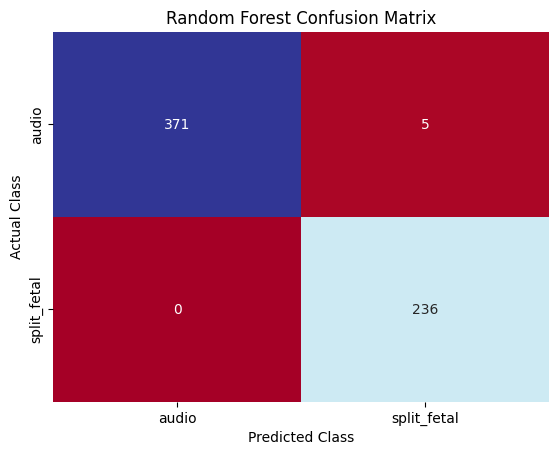

In [88]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, rf_predictions)

cm_rf = confusion_matrix(y_test, rf_predictions)

# Evaluate the Logistic Regression model
accuracy_rf = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))

# Create a colored heatmap for the confusion matrix with red, black, and yellow colors
sns.heatmap(cm_rf, annot=True, fmt='d', cmap=sns.color_palette("RdYlBu", as_cmap=True), cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

Logistic Regression Accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       376
           1       0.94      0.99      0.96       236

    accuracy                           0.97       612
   macro avg       0.97      0.98      0.97       612
weighted avg       0.97      0.97      0.97       612


Confusion Matrix:
[[361  15]
 [  2 234]]


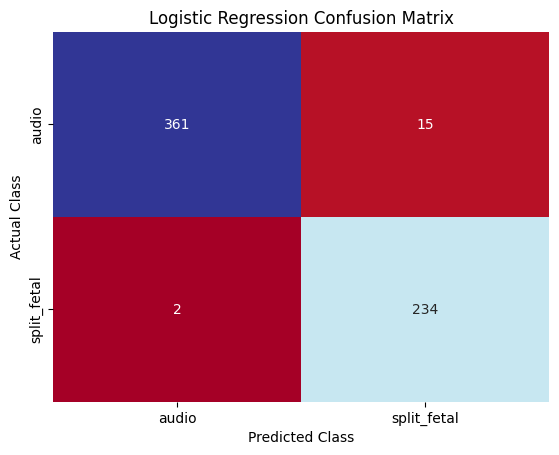

In [89]:
# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
logreg_predictions = logreg_model.predict(X_test)
cf_log = confusion_matrix(y_test, logreg_predictions)

# Evaluate the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, logreg_predictions)
print(f"Logistic Regression Accuracy: {accuracy_logreg:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, logreg_predictions))
print("\nConfusion Matrix:")
print(cf_log)

# Create a colored heatmap for the confusion matrix with red, black, and yellow colors
sns.heatmap(cf_log, annot=True, fmt='d', cmap=sns.color_palette("RdYlBu", as_cmap=True), cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       376
           1       0.96      0.99      0.97       236

    accuracy                           0.98       612
   macro avg       0.98      0.98      0.98       612
weighted avg       0.98      0.98      0.98       612

Decision Tree Confusion Matrix:
[[366  10]
 [  2 234]]


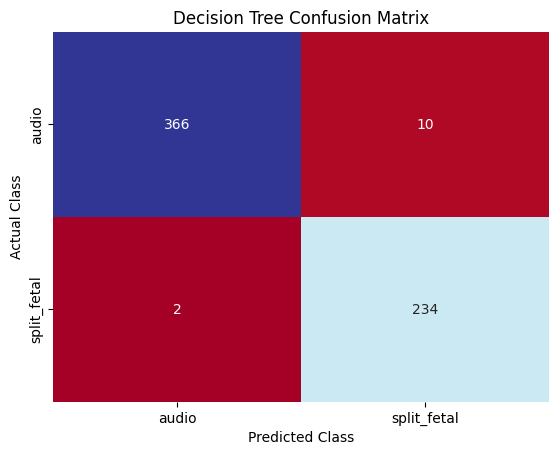

In [90]:
# Create and train the model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

# Make predictions
predictions_dt = decision_tree.predict(X_test)

# Print Classification Report and Confusion Matrix
print("Decision Tree Classification Report:")
print(classification_report(y_test, predictions_dt))
print("Decision Tree Confusion Matrix:")
conf_matrix_dt = confusion_matrix(y_test, predictions_dt)
print(conf_matrix_dt)

# Create a colored heatmap for the confusion matrix with red, black, and yellow colors
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap=sns.color_palette("RdYlBu", as_cmap=True), cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()



SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       376
           1       0.97      1.00      0.99       236

    accuracy                           0.99       612
   macro avg       0.99      0.99      0.99       612
weighted avg       0.99      0.99      0.99       612

SVM Confusion Matrix:
[[369   7]
 [  0 236]]


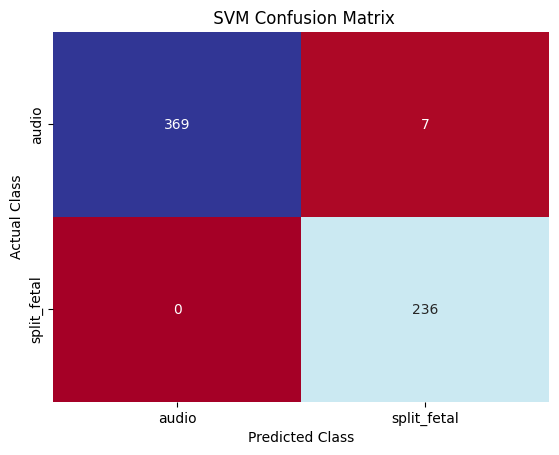

In [91]:
# Create and train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# Make predictions
predictions_svm = svm_classifier.predict(X_test)

# Print Classification Report and Confusion Matrix
print("SVM Classification Report:")
print(classification_report(y_test, predictions_svm))
print("SVM Confusion Matrix:")
conf_matrix_svm = confusion_matrix(y_test, predictions_svm)
print(conf_matrix_svm)

# Create a colored heatmap for the confusion matrix with red, black, and yellow colors
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap=sns.color_palette("RdYlBu", as_cmap=True), cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title(' SVM Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()


KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       360
           1       0.99      1.00      1.00       252

    accuracy                           1.00       612
   macro avg       1.00      1.00      1.00       612
weighted avg       1.00      1.00      1.00       612

KNN Confusion Matrix:
[[358   2]
 [  0 252]]


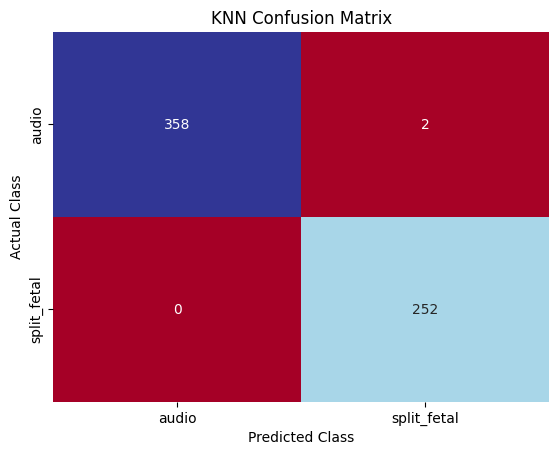

In [72]:
# Create and train the model
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

# Make predictions
predictions_knn = knn_classifier.predict(X_test)

# Print Classification Report
print("KNN Classification Report:")
print(classification_report(y_test, predictions_knn))

# Print Confusion Matrix
print("KNN Confusion Matrix:")
conf_matrix_knn = confusion_matrix(y_test, predictions_knn)
print(conf_matrix_knn)


# Create a colored heatmap for the confusion matrix with red, black, and yellow colors
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap=sns.color_palette("RdYlBu", as_cmap=True), cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       360
           1       0.98      0.97      0.98       252

    accuracy                           0.98       612
   macro avg       0.98      0.98      0.98       612
weighted avg       0.98      0.98      0.98       612

Naive Bayes Confusion Matrix:
[[356   4]
 [  7 245]]


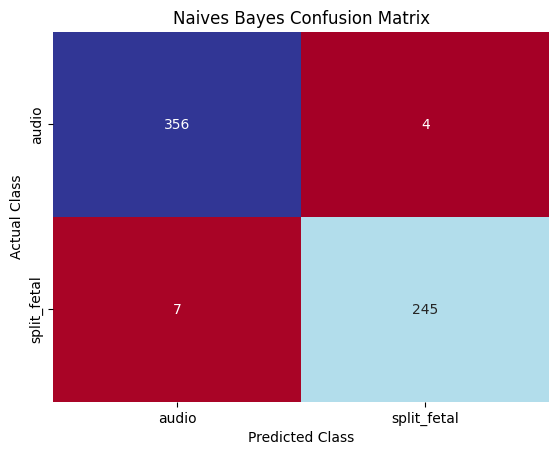

In [73]:
# Create and train the model
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

# Make predictions
predictions_nb = naive_bayes.predict(X_test)

# Print Classification Report
print("Naive Bayes Classification Report:")
print(classification_report(y_test, predictions_nb))

# Print Confusion Matrix
print("Naive Bayes Confusion Matrix:")
conf_matrix_nb = confusion_matrix(y_test, predictions_nb)
print(conf_matrix_nb)


# Create a colored heatmap for the confusion matrix with red, black, and yellow colors
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap=sns.color_palette("RdYlBu", as_cmap=True), cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Naives Bayes Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()


In [74]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

classifier = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=10)

Epoch 1/20
245/245 [==============================] - 2s 3ms/step - loss: 0.3164 - accuracy: 0.9020
Epoch 2/20
245/245 [==============================] - 1s 3ms/step - loss: 0.1329 - accuracy: 0.9592
Epoch 3/20
245/245 [==============================] - 1s 3ms/step - loss: 0.0948 - accuracy: 0.9706
Epoch 4/20
245/245 [==============================] - 1s 2ms/step - loss: 0.0795 - accuracy: 0.9763
Epoch 5/20
245/245 [==============================] - 1s 2ms/step - loss: 0.0752 - accuracy: 0.9734
Epoch 6/20
245/245 [==============================] - 1s 3ms/step - loss: 0.0609 - accuracy: 0.9808
Epoch 7/20
245/245 [==============================] - 1s 3ms/step - loss: 0.0625 - accuracy: 0.9788
Epoch 8/20
245/245 [==============================] - 1s 2ms/step - loss: 0.0584 - accuracy: 0.9779
Epoch 9/20
245/245 [==============================] - 1s 3ms/step - loss: 0.0647 - accuracy: 0.9767
Epoch 10/20
245/245 [==============================] - 1s 3ms/step - loss: 0.0481 - accuracy: 0.9837

The team used a classification matrix, also known as a confusion matrix, which is a table that is used to evaluate the performance of a classification algorithm. It provides a comprehensive view of the performance of a model by breaking down the predicted and actual classes into four categories: true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). From these values, various performance metrics can be derived. The features of a classification matrix and their significance are discussed below:

True Positives (TP) represent the number of instances correctly predicted as positive by the model. In other words, these are the cases where the model correctly identified the positive class. True Negatives (TN), represents the number of instances correctly predicted as negative by the model. These are the cases where the model correctly identified the absence of the positive class.
AdditionLLY, False Positives (FP) represent the number of instances incorrectly predicted as positive by the model. In other words, these are the cases where the model predicted the positive class, but it was not present. Furthermore,
False Negatives (FN) represents the number of instances incorrectly predicted as negative by the model. These are the cases where the model predicted the absence of the positive class, but it was actually present.

Accuracy is the overall correctness of the model. It is the ratio of correctly predicted instances (TP + TN) to the total number of instances. It provides a general sense of the model's performance. Precision (Positive Predictive Value)focuses on the accuracy of positive predictions. It is the ratio of true positives to the sum of true positives and false positives. Precision is valuable when the cost of false positives is high.
Recall (Sensitivity, True Positive Rate) focuses on the ability of the model to capture all positive instances. It is the ratio of true positives to the sum of true positives and false negatives. Recall is important when the cost of false negatives is high. Specificity (True Negative Rate) that measures the ability of the model to correctly identify negative instances. It is the ratio of true negatives to the sum of true negatives and false positives.
F1 Score is the  Harmonic mean of precision and recall. It provides a balance between precision and recall, making it useful when there is an uneven class distribution.







# **References**
M. Samieinasab and R. Sameni, Fetal phonocardiogram extraction using single channel blind source separation, 2015 23rd Iranian Conference on Electrical Engineering, Tehran, 2015, pp. 78-83. DOI: https://doi.org/10.1109/IranianCEE.2015.7146186

Chengyu Liu, David Springer, Qiao Li, Benjamin Moody, Ricardo Abad Juan, Francisco J Chorro, Francisco Castells, José Millet Roig, Ikaro Silva, Alistair E W Johnson, Zeeshan Syed, Samuel E Schmidt, Chrysa D Papadaniil, Leontios Hadjileontiadis, Hosein Naseri, Ali Moukadem, Alain Dieterlen, Christian Brandt, Hong Tang, Maryam Samieinasab, Mohammad Reza Samieinasab, Reza Sameni, Roger G Mark, and Gari D Clifford. An open access database for the evaluation of heart sound algorithms, Physiological Meassurement. 2016 Dec; 37(12):2181-2213. DOI: https://doi.org/10.1088/0967-3334/37/12/2181

Audacity, open source audio software. https://www.audacityteam.org/ [Accessed: 7 January 2021]

    

